# RNN

## Build RNN

Load data and libraries

In [71]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import random

In [72]:
df = pd.read_csv('data/cleaned_eda.csv')
df = df[df["GENDER"].isin(["female", "male"])]
df.head()

,lemmatized_lyrics,GENDER
0,"['oh', 'danny', 'boy', 'pipe', 'pipe', 'callin...",female
1,"['never', 'feel', 'thing', 'real', 'im', 'away...",female
2,"['really', 'cant', 'stay', 'baby', 'cold', 'ou...",female
3,"['life', 'ive', 'waiting', 'wonderful', 'one',...",female
4,"['ill', 'get', 'taxi', 'honey', 'better', 'rea...",female


Create a token-to-index dictionary

In [73]:
tokenized = df["lemmatized_lyrics"]

all_tokens = [token for row in tokenized for token in row]
vocab = {token: i + 2 for i, token in enumerate(Counter(all_tokens).keys())}
vocab["<pad>"] = 0
vocab["<unk>"] = 1
vocab_size = len(vocab)

Encode lyrics and labels

In [74]:
def encode(tokens): return [vocab.get(t, 1) for t in tokens]
X_encoded = tokenized.apply(encode)
y_encoded = df["GENDER"].map({"female": 0, "male": 1}).tolist()

Truncate and pad sequences

In [75]:
seq_len = 100
X_tensor = [torch.tensor(x[:seq_len]) for x in X_encoded]
X_padded = pad_sequence(X_tensor, batch_first=True, padding_value=0)
y_tensor = torch.tensor(y_encoded)

Preparing preprocessed dataset for training and testing

In [76]:
indices = list(range(len(X_padded)))
random.shuffle(indices)

split = int(0.8 * len(indices))
train_idx, test_idx = indices[:split], indices[split:]

X_train, X_test = X_padded[train_idx], X_padded[test_idx]
y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

Compute class frequencies

In [79]:
from collections import Counter
import torch

label_counts = Counter(y_train.tolist())
total = sum(label_counts.values())

class_weights = [total / label_counts[i] for i in range(len(label_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float32)

Set up hyperparameters

In [80]:
embed_size = 64
num_hiddens = 128
output_size = 2
lr = 0.01
num_epochs = 5

embedding = nn.Embedding(vocab_size, embed_size)
rnn = RNNScratch(embed_size, num_hiddens)
linear = nn.Linear(num_hiddens, output_size)
dropout = nn.Dropout(p=0.5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

### Train RNN with Pytorch

In [81]:
for epoch in range(num_epochs):
    rnn.train()
    dropout.train()
    embedding.train()

    total_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_embed = embedding(X_batch)
        X_input = X_embed.permute(1, 0, 2) 

        outputs, (state,) = rnn(X_input)
        dropped = dropout(outputs[-1])
        y_hat = linear(dropped)

        loss = loss_fn(y_hat, y_batch)
        loss.backward()

        with torch.no_grad():
            for param in rnn.parameters():
                param -= lr * param.grad
                param.grad.zero_()
            for param in linear.parameters():
                param -= lr * param.grad
                param.grad.zero_()
            for param in embedding.parameters():
                param -= lr * param.grad
                param.grad.zero_()

        total_loss += loss.item()
        correct += (y_hat.argmax(1) == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Train Accuracy={train_acc:.4f}")

Epoch 1: Loss=342.4510, Train Accuracy=0.6223
Epoch 2: Loss=341.7393, Train Accuracy=0.5865
Epoch 3: Loss=341.8852, Train Accuracy=0.5836
Epoch 4: Loss=341.6976, Train Accuracy=0.5875
Epoch 5: Loss=341.5004, Train Accuracy=0.5673


Evaluate on the test set

In [82]:
import numpy as np
import matplotlib.pyplot as plt

rnn.eval()
dropout.eval()
embedding.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_embed = embedding(X_batch)
        X_input = X_embed.permute(1, 0, 2)

        outputs, (state,) = rnn(X_input)
        logits = linear(outputs[-1])  # no dropout here

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.tolist())
        all_probs.extend(probs[:, 1].tolist())
        all_labels.extend(y_batch.tolist())

# Compute test accuracy
all_preds_np = np.array(all_preds)
all_labels_np = np.array(all_labels)
test_acc = (all_preds_np == all_labels_np).mean()
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6378


Function to compute accuracy

In [83]:
def compute_metrics(y_true, y_pred, y_prob, threshold=0.5):
    TP = sum((y_pred[i] == 1 and y_true[i] == 1) for i in range(len(y_true)))
    TN = sum((y_pred[i] == 0 and y_true[i] == 0) for i in range(len(y_true)))
    FP = sum((y_pred[i] == 1 and y_true[i] == 0) for i in range(len(y_true)))
    FN = sum((y_pred[i] == 0 and y_true[i] == 1) for i in range(len(y_true)))

    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    sorted_pairs = sorted(zip(y_prob, y_true), reverse=True)
    TPRs, FPRs = [], []
    P = sum(y_true)
    N = len(y_true) - P
    TP = FP = 0
    for prob, label in sorted_pairs:
        if label == 1:
            TP += 1
        else:
            FP += 1
        TPRs.append(TP / P if P else 0)
        FPRs.append(FP / N if N else 0)
    auc = np.trapz(TPRs, FPRs)

    return accuracy, precision, recall, f1, auc, TPRs, FPRs


Plot ROC curve and state metrics

Accuracy : 0.6378
Precision: 0.7800
Recall   : 0.7452
F1-score : 0.7622
AUC      : 0.4962


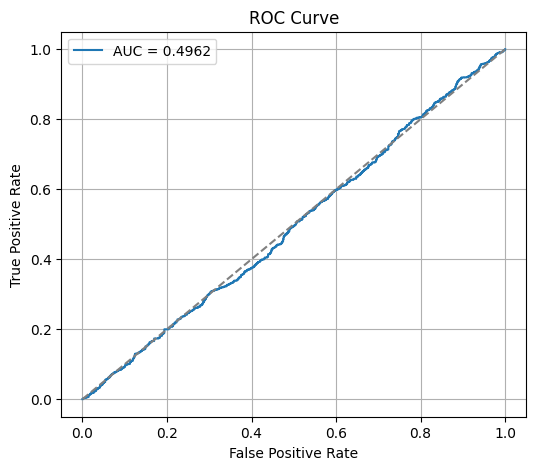

In [84]:
accuracy, precision, recall, f1, auc_score, tprs, fprs = compute_metrics(all_labels, all_preds, all_probs)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc_score:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fprs, tprs, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Plot Confusion Matrix

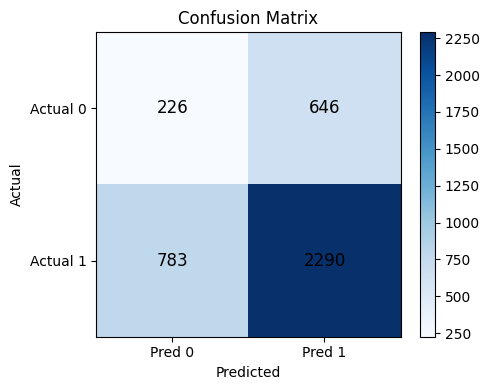

In [85]:
TP = sum((p == 1 and y == 1) for p, y in zip(all_preds, all_labels))
TN = sum((p == 0 and y == 0) for p, y in zip(all_preds, all_labels))
FP = sum((p == 1 and y == 0) for p, y in zip(all_preds, all_labels))
FN = sum((p == 0 and y == 1) for p, y in zip(all_preds, all_labels))

conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(conf_matrix, cmap="Blues")

for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_matrix[i, j], ha="center", va="center", fontsize=12)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred 0", "Pred 1"])
ax.set_yticklabels(["Actual 0", "Actual 1"])
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
plt.colorbar(im)
plt.tight_layout()
plt.show()